In [24]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow

In [6]:
img = Image.open("examples/input.png")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = 'cpu'
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cpu


Using cache found in /users/eleves-a/2018/nicolas.lopes/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

In [9]:
import copy
import requests
import torch.nn.functional as F

from tqdm import tqdm

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def get_prediction(scores):
    '''Gets the index of max prob and the prob
    '''
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    # output the prediction
    return idx[0].item(), probs[0].item()

In [10]:
input_tensor  = preprocess_image("examples/input.png", transform)


In [11]:
scores = model(input_tensor)
# category_index, _ = get_prediction(scores)

In [16]:
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

idx = print_preds(scores)

0.266 -> ['n02108422', 'bull_mastiff']
0.062 -> ['n02108089', 'boxer']
0.039 -> ['n02123159', 'tiger_cat']
0.033 -> ['n02110958', 'pug']
0.023 -> ['n02123045', 'tabby']


In [17]:
idx

array([243, 242, 282, 254, 281, 245, 246, 292, 180, 285,  21,  22, 127,
       197, 163, 291, 182, 405, 159, 226, 192, 976,  23, 247, 179, 172,
        89, 204, 225, 146, 132, 155, 209, 138, 144, 251, 143, 202, 235,
       437,  11, 133, 128, 208, 195, 154, 198, 974,  80,  34,   9, 460,
       201, 139, 276, 255, 200, 805, 340, 404, 284, 286, 972,  85,  24,
       657, 701, 958,  81, 980, 170, 256, 462, 811, 882, 315, 744,  93,
       234, 233, 913, 755, 287, 900, 978, 812, 299, 196, 833, 238, 872,
        71, 840, 178,  69, 554, 362, 134, 283, 187, 262, 539, 478, 189,
        83,  18, 700,  86, 442,  92, 620, 977, 185, 359,  13, 135, 129,
       749,  87, 184, 999,   7, 724, 289, 682, 832, 131,  39, 557,  33,
       318, 211, 370, 386, 402, 199, 160, 525, 783, 296,  19,  10, 150,
       622, 288, 471, 839, 895, 141, 892, 136, 540, 174, 162, 908, 114,
        99, 881, 100, 731, 753, 845, 217, 644,   2, 354, 361, 377, 676,
       381, 388, 375, 733, 543, 207,  91, 413, 417, 249, 595, 14

In [12]:
scores

tensor([[-2.5133e-01, -2.0502e+00,  9.2803e-01,  4.1529e-01,  6.5322e-02,
         -1.5651e+00, -4.2585e-01,  1.1727e+00,  1.4332e-01,  1.8791e+00,
          1.0600e+00,  2.0251e+00,  1.8890e-01,  1.2212e+00, -5.3569e-01,
         -9.7666e-02,  5.1286e-01,  3.3336e-01,  1.2608e+00,  1.0612e+00,
          7.7661e-01,  3.1386e+00,  3.0254e+00,  2.6759e+00,  1.6670e+00,
          3.6544e-01,  5.8107e-01, -4.4373e-02, -1.1290e-02,  1.5425e-01,
          3.6608e-01, -5.1635e-01, -9.1371e-01,  1.1347e+00,  1.8841e+00,
          4.9246e-02,  2.5157e-01, -5.9127e-01,  4.5426e-01,  1.1480e+00,
          2.8812e-01, -1.6004e-01,  6.9766e-01, -7.4270e-02,  7.3251e-02,
          1.3344e-01,  2.7733e-01, -3.2725e-01, -2.0225e-01, -3.6588e-01,
          3.5668e-01,  6.7176e-01, -7.6848e-01,  1.1796e-01, -1.5610e+00,
         -4.7769e-01, -1.4962e+00,  1.1372e-01,  3.3331e-01, -3.7994e-01,
         -5.1352e-01, -1.3172e+00, -7.9755e-01, -1.7669e-01,  4.9722e-02,
          2.0921e-01, -8.5113e-01, -8.

Using attention_rollout


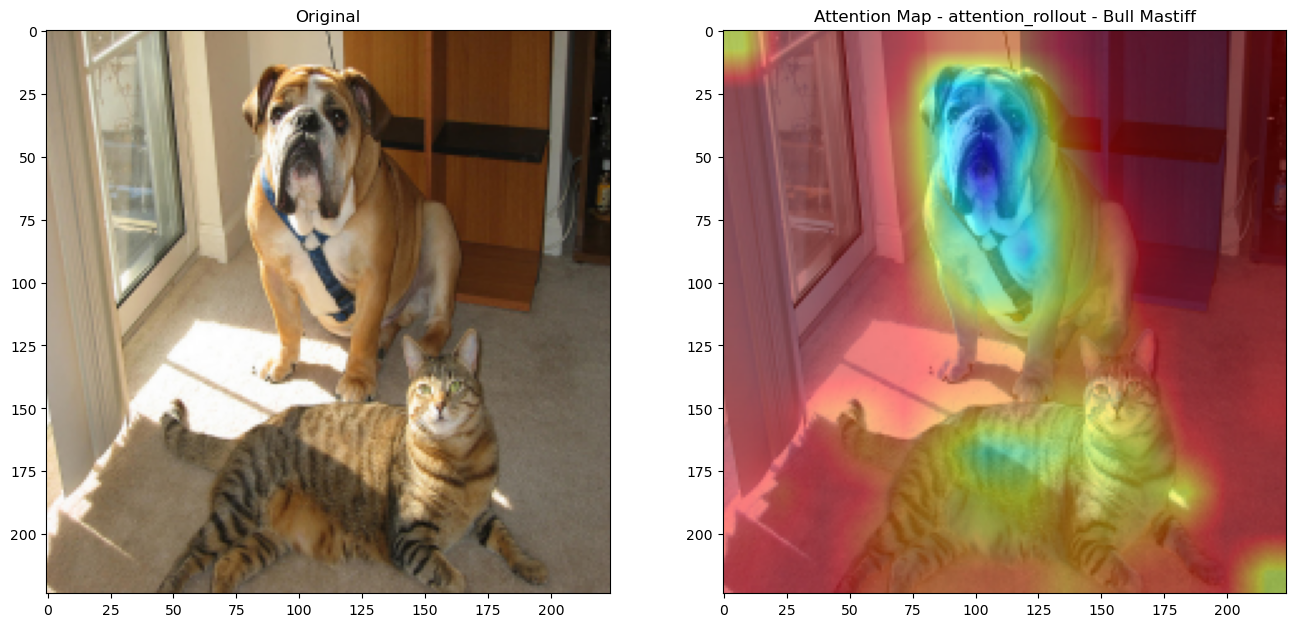

In [26]:
#@title Select the rollout strategy to be used and display results
#@markdown **Note** that for `grad_attention_rollout` passing a category index is mandatory.
rollout_strategy = "attention_rollout" #@param ["attention_rollout", "grad_attention_rollout", "attention_flow"]
category_index =  243#@param {type:"integer"} 282 cat

print(f"Using {rollout_strategy}")

input_tensor  = preprocess_image("examples/input.png", transform)

if rollout_strategy == "grad_attention_rollout" and category_index < 0:
    raise Exception("Category index is mandatory when using Gradient Attention Rollout")

elif rollout_strategy == "grad_attention_rollout" and category_index > 0:
    grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
    mask = grad_rollout(input_tensor, category_index)
    name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
        DISCARD_RATIO, "mean")

elif rollout_strategy == "attention_rollout":
    attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
    mask = attention_rollout(input_tensor)
    name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    
elif rollout_strategy == "attention_flow":
    attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
    mask = attention_flow(input_tensor)
    name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")

np_img = np.array(img)[:, :, ::-1]
mask = cv2.resize(mask, (np_img.shape[1], np_img.shape[0]))
mask = show_mask_on_image(np_img, mask)

# mask = (mask - mask.min()) / (mask.max() - mask.min())
# mask = mask.clip(0.7,1)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title(f'Attention Map - {rollout_strategy} - Bull Mastiff')
_ = ax1.imshow(img)
_ = ax2.imshow(mask)